
  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], G Loss: 0.3599, D Loss: 0.0588


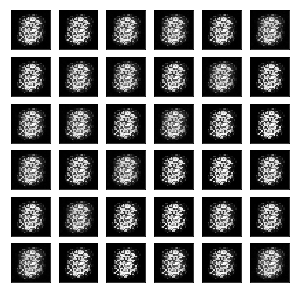


  4%|▍         | 1/25 [00:19<07:49, 19.58s/it]

Epoch[2/25], G Loss: 0.3579, D Loss: 0.0332


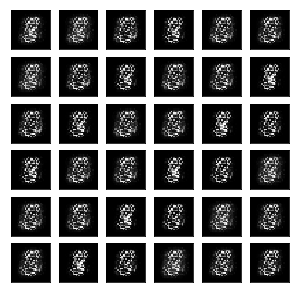


  8%|▊         | 2/25 [00:43<08:20, 21.74s/it]

Epoch[3/25], G Loss: 0.2959, D Loss: 0.0701


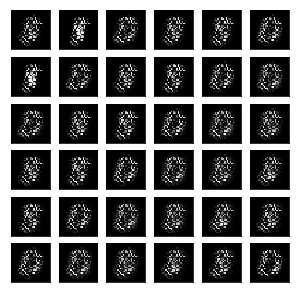


 12%|█▏        | 3/25 [01:04<07:54, 21.57s/it]

Epoch[4/25], G Loss: 0.3616, D Loss: 0.0520


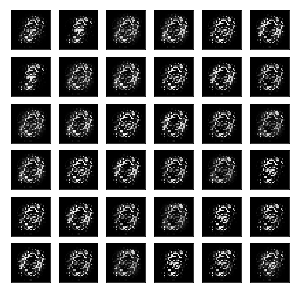


 16%|█▌        | 4/25 [01:25<07:31, 21.49s/it]

Epoch[5/25], G Loss: 0.3744, D Loss: 0.0664


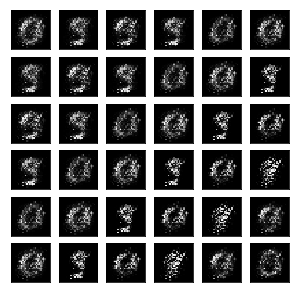


 20%|██        | 5/25 [01:48<07:12, 21.60s/it]

Epoch[6/25], G Loss: 0.3323, D Loss: 0.0950


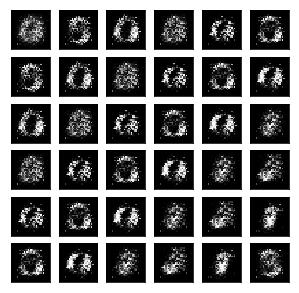


 24%|██▍       | 6/25 [02:10<06:52, 21.69s/it]

Epoch[7/25], G Loss: 0.3540, D Loss: 0.0696


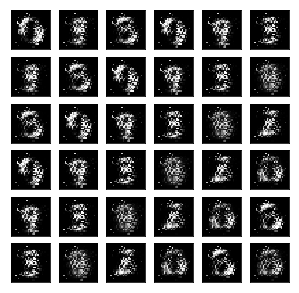


 28%|██▊       | 7/25 [02:31<06:29, 21.66s/it]

Epoch[8/25], G Loss: 0.3773, D Loss: 0.0466


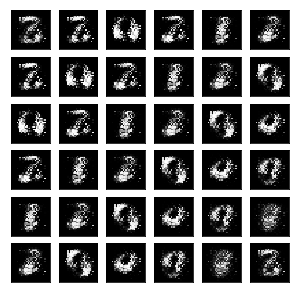


 32%|███▏      | 8/25 [02:42<05:46, 20.36s/it]

Epoch[9/25], G Loss: 0.3649, D Loss: 0.0568


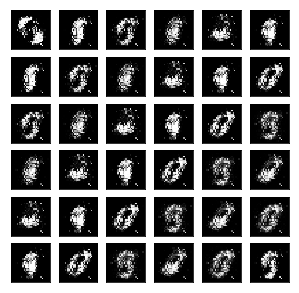


 36%|███▌      | 9/25 [02:55<05:12, 19.51s/it]

Epoch[10/25], G Loss: 0.3750, D Loss: 0.0433


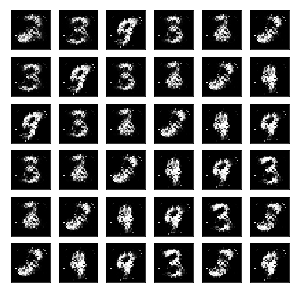


 40%|████      | 10/25 [03:10<04:45, 19.04s/it]

Epoch[11/25], G Loss: 0.3667, D Loss: 0.0504


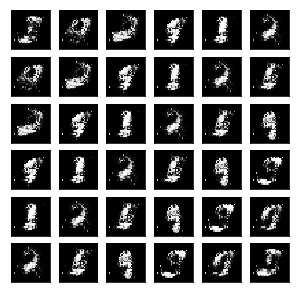


 44%|████▍     | 11/25 [03:27<04:23, 18.83s/it]

Epoch[12/25], G Loss: 0.3685, D Loss: 0.0425


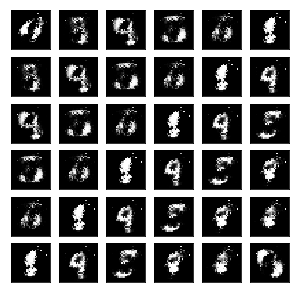


 48%|████▊     | 12/25 [03:50<04:09, 19.23s/it]

Epoch[13/25], G Loss: 0.3750, D Loss: 0.0373


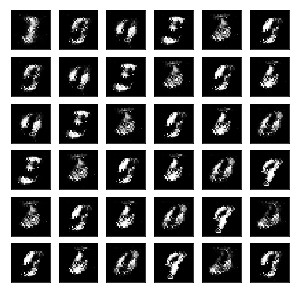


 52%|█████▏    | 13/25 [04:06<03:47, 18.96s/it]

Epoch[14/25], G Loss: 0.3688, D Loss: 0.0423


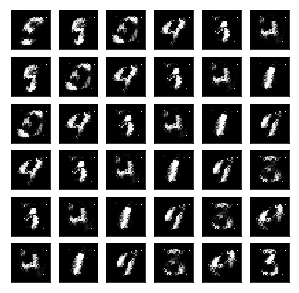


 56%|█████▌    | 14/25 [04:22<03:26, 18.73s/it]

Epoch[15/25], G Loss: 0.3642, D Loss: 0.0495


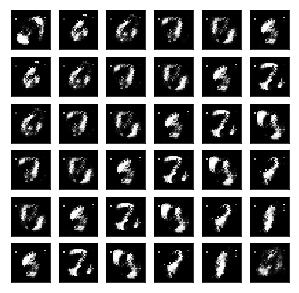


 60%|██████    | 15/25 [04:38<03:05, 18.59s/it]

Epoch[16/25], G Loss: 0.3732, D Loss: 0.0489


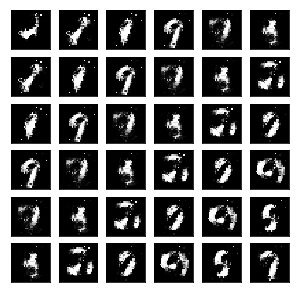


 64%|██████▍   | 16/25 [04:54<02:45, 18.40s/it]

Epoch[17/25], G Loss: 0.3696, D Loss: 0.0474


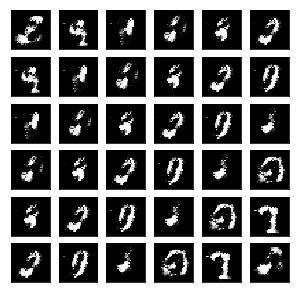


 68%|██████▊   | 17/25 [05:10<02:26, 18.26s/it]

Epoch[18/25], G Loss: 0.3747, D Loss: 0.0412


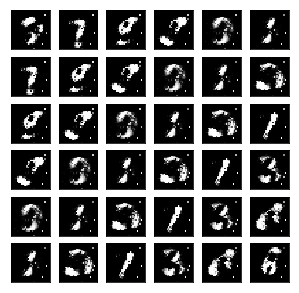


 72%|███████▏  | 18/25 [05:25<02:06, 18.08s/it]

Epoch[19/25], G Loss: 0.3660, D Loss: 0.0482


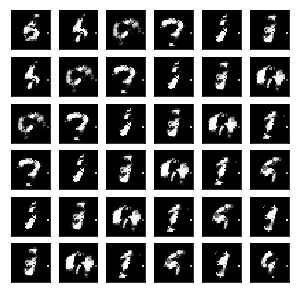


 76%|███████▌  | 19/25 [05:41<01:47, 17.95s/it]

Epoch[20/25], G Loss: 0.3756, D Loss: 0.0447


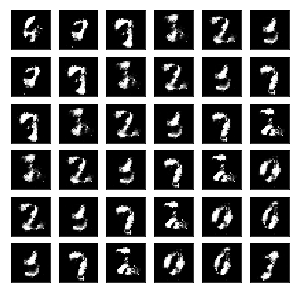


 80%|████████  | 20/25 [05:57<01:29, 17.89s/it]

Epoch[21/25], G Loss: 0.3606, D Loss: 0.0530


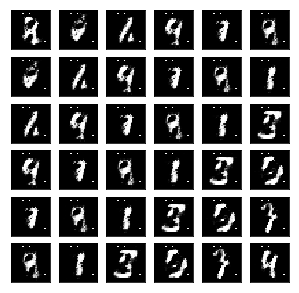


 84%|████████▍ | 21/25 [06:14<01:11, 17.83s/it]

Epoch[22/25], G Loss: 0.3848, D Loss: 0.0377


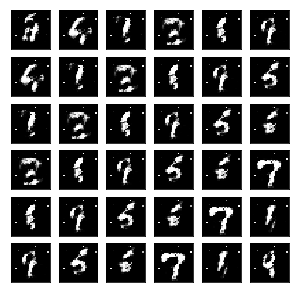


 88%|████████▊ | 22/25 [06:29<00:53, 17.72s/it]

Epoch[23/25], G Loss: 0.3785, D Loss: 0.0406


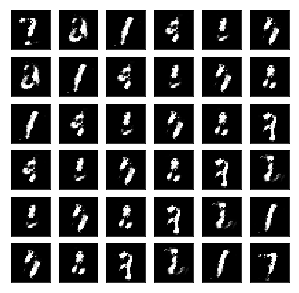


 92%|█████████▏| 23/25 [06:46<00:35, 17.66s/it]

Epoch[24/25], G Loss: 0.3746, D Loss: 0.0436


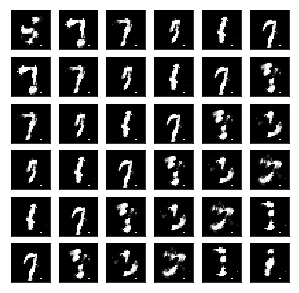


 96%|█████████▌| 24/25 [07:02<00:17, 17.60s/it]

Epoch[25/25], G Loss: 0.3711, D Loss: 0.0448


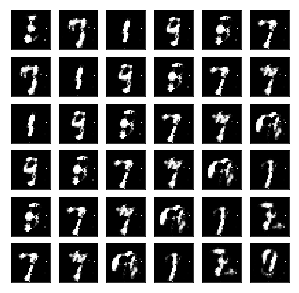


100%|██████████| 25/25 [07:21<00:00, 17.66s/it]


In [5]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.ls_gan import *
    
# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = LSGAN(image_size=784,
              hidden_dim=400,
              z_dim=20)

# Init trainer
trainer = LSGANTrainer(model=model,
                       train_iter=train_iter,
                       val_iter=val_iter,
                       test_iter=test_iter,
                       viz=True)

# Train
trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)